In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from PIL import Image
import random

import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split, DataLoader, Dataset
from torchvision import datasets, transforms
#from torch.utils.tensorboard import SummaryWriter

from transformers import TrOCRProcessor, VisionEncoderDecoderModel, default_data_collator
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
import evaluate
import albumentations as A


Завиксируем всю случайность!

In [2]:
seed = 23
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.determenistic = True

Соберем наш датасет из полученных файлов

In [3]:
basketball_df = pd.read_csv('for_train\\train_bascetball.csv')
streetball_df = pd.read_csv('for_train\\train_streetball.csv')
volleyball_df = pd.read_csv('for_train\\train_volleyball.csv')

res_df = pd.concat([basketball_df, streetball_df, volleyball_df], axis=0)
res_df.shape

(150637, 3)

Разобьем датасет на train test и eval части

In [4]:
diff_df, test_df, = train_test_split(res_df, test_size=0.2, shuffle=True)
train_df, eval_df = train_test_split(diff_df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
eval_df.reset_index(drop=True, inplace=True)

In [5]:
transform = A.Compose([
    A.Perspective(),
    A.Rotate(45),
    A.Resize(height=70, width=70),
    A.RandomCrop(width=64, height=64)   
])

In [6]:
class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=3, transforms = None):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      
        file_name = self.df['file_name'][idx]
        text = str(self.df['text'][idx])
   
        image = Image.open(file_name).convert("RGB")
        
        if self.transforms is not None:
            image = self.transforms(image=np.array(image))["image"]
        
        #image = image.resize((64, 64))
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

Создадим наши датасеты

In [7]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = IAMDataset(root_dir='C:\\Users\\Mytre\\OneDrive\\Документы\\Data\\Work\\',
                           df=train_df,
                           processor=processor,
                           transforms=transform)
test_dataset = IAMDataset(root_dir='C:\\Users\\Mytre\\OneDrive\\Документы\\Data\\Work\\',
                           df=test_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='C:\\Users\\Mytre\\OneDrive\\Документы\\Data\\Work\\',
                           df=eval_df,
                           processor=processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [8]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))
print("Number of testing examples:", len(test_dataset))

Number of training examples: 96407
Number of validation examples: 24102
Number of testing examples: 30128


In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=3, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=3)
test_dataloader = DataLoader(test_dataset, batch_size=32)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#tensor_board = SummaryWriter()

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")
model.to(device)

optimizer = AdamW(model.parameters(), lr=0.00005)
scheduler = StepLR(optimizer, step_size=1, gamma=0.996)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model = VisionEncoderDecoderModel.from_pretrained('model')
model.to(device)
print(device)

Сконфигурируем нашу модель

In [11]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 4
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 10

Оопределим метрику

In [12]:
acc_metric = evaluate.load("accuracy")
cer_metric = evaluate.load("cer")

In [13]:
def compute_acc(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    #label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    #label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    x = [] 
    for j in pred_str:       
        if j.isdigit():
            x.append(int(j))
        else:
            x.append(1000)
    label_ids = [int(x) for x in label_ids]       
    acc = acc_metric.compute(predictions=x, references=label_ids)

    return acc

def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [14]:
def drow_graf(acc, loss):

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

    # Plot the data on the first subplot
    ax1.plot(list(range(len(acc))), acc, color='green')
    ax1.plot(list(range(len(acc))), acc, color='red')
    ax1.set_title('Validation accuracy')

    # Plot the data on the second subplot
    ax2.plot(list(range(len(loss))), loss)
    ax2.set_title('Training loss')

    # Add a title to the figure
    fig.suptitle('Trigonometric Functions')

    # Display the plot
    plt.show()

Epoch 1 start, lr=5e-05


  0%|          | 0/32136 [00:00<?, ?it/s]

Train loss: 1.188995708476056


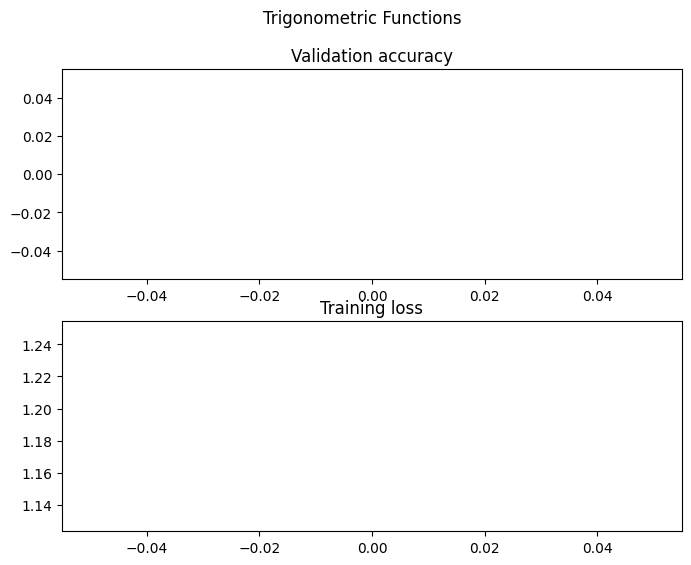

lr=4.9500000000000004e-05
Train loss: 1.0111712719844854


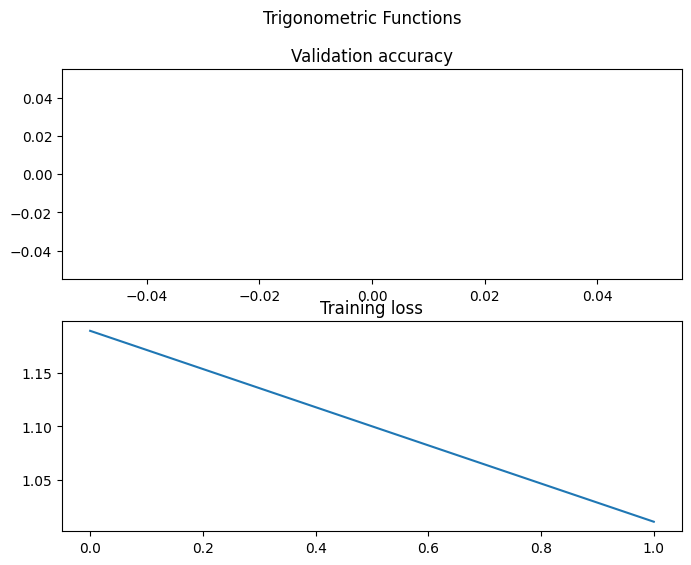

lr=4.9005e-05
Train loss: 0.8955808576123192


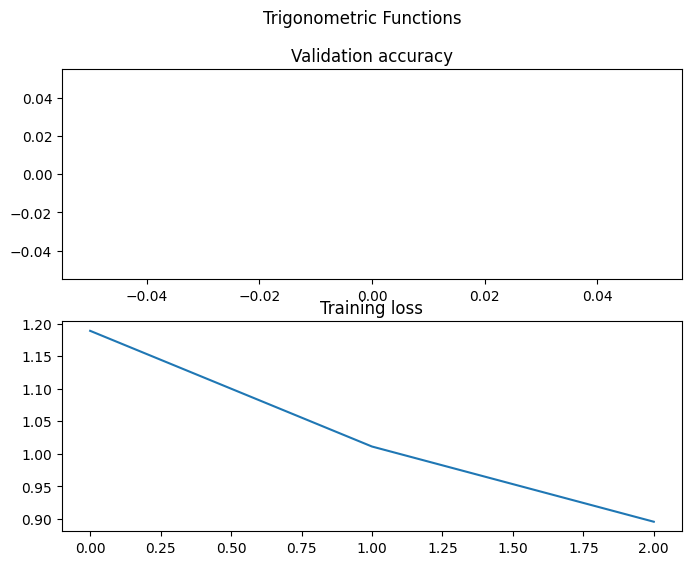

lr=4.851495e-05
Train loss: 0.7763542602047272


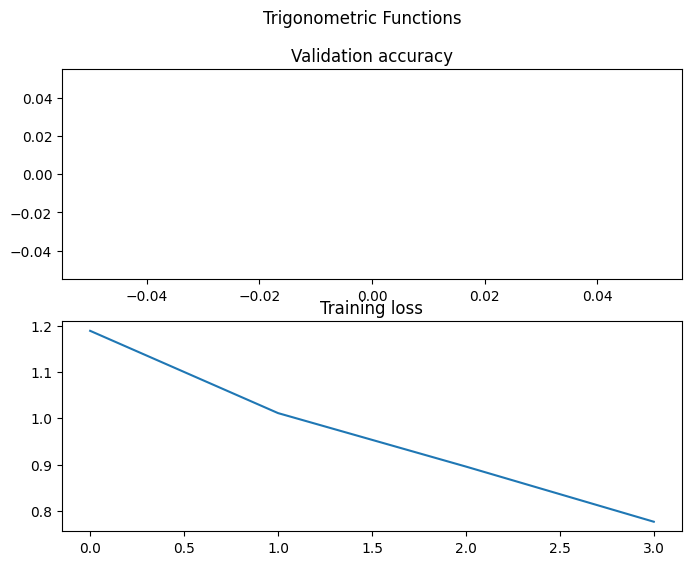

lr=4.8029800500000004e-05
Train loss: 0.6885415829848449


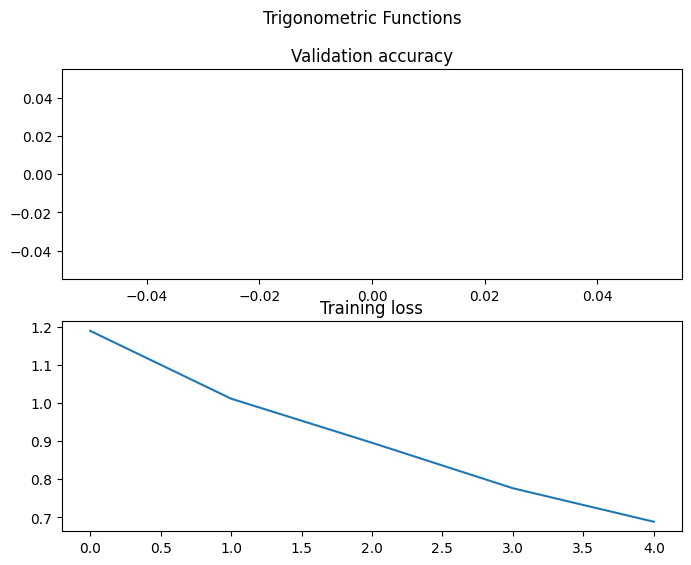

lr=4.7549502495000005e-05
Train loss: 0.626651776637925


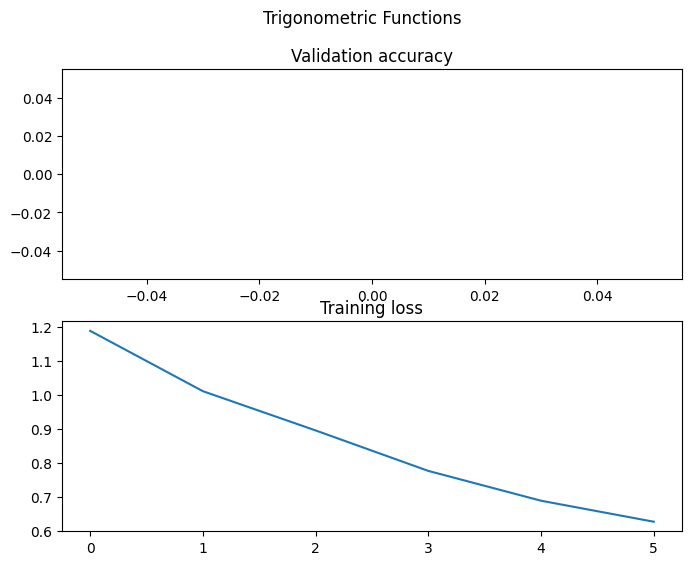

lr=4.707400747005001e-05
Train loss: 0.5804700232905089


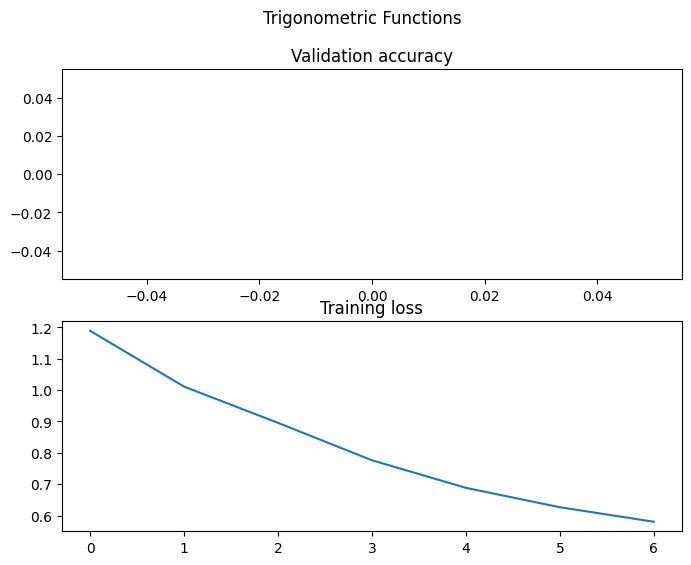

lr=4.660326739534951e-05
Train loss: 0.5392304149417706


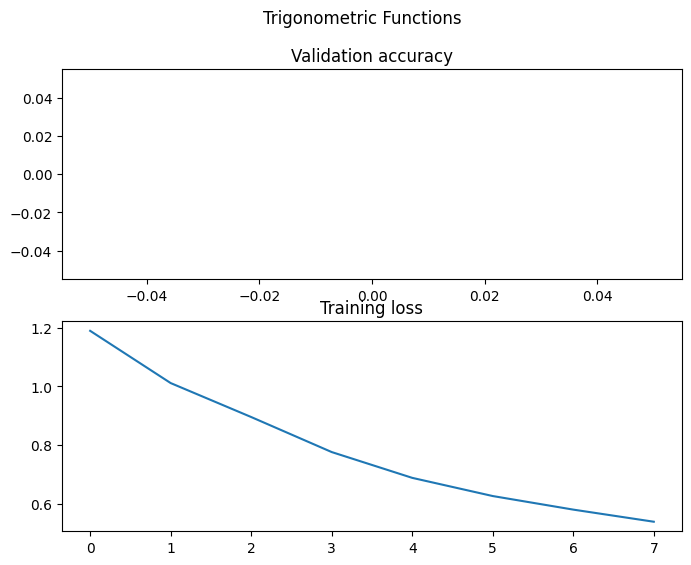

lr=4.6137234721396015e-05
Train loss: 0.5049995299136893


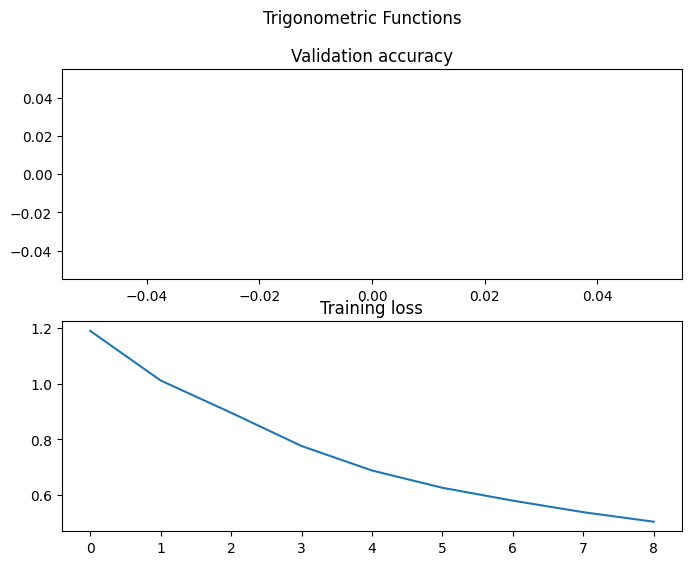

lr=4.567586237418205e-05
Train loss: 0.4783406559710072


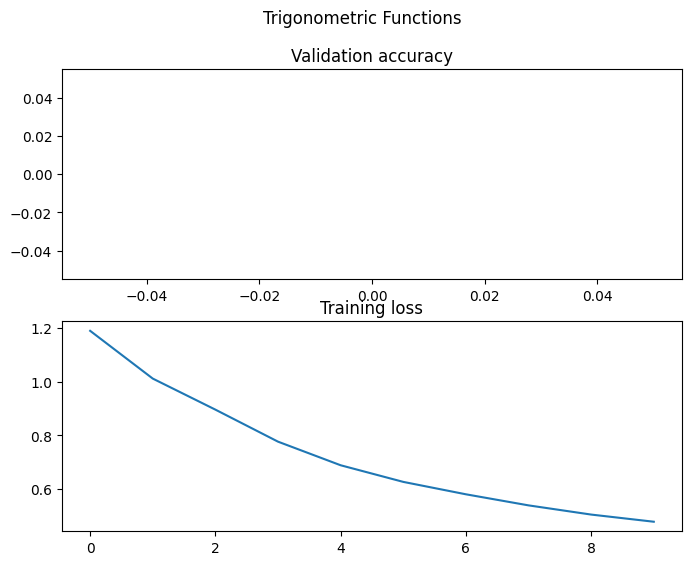

lr=4.5219103750440234e-05
Train loss: 0.45727024404879724


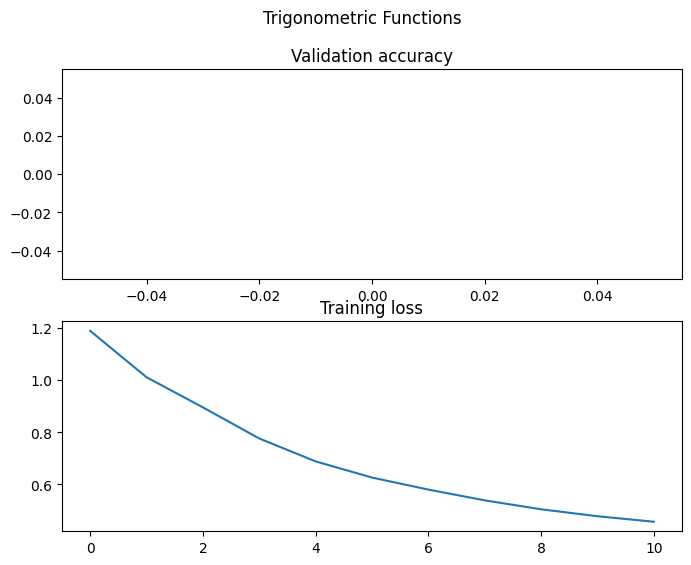

lr=4.4766912712935834e-05
Train loss: 0.4373623124888881


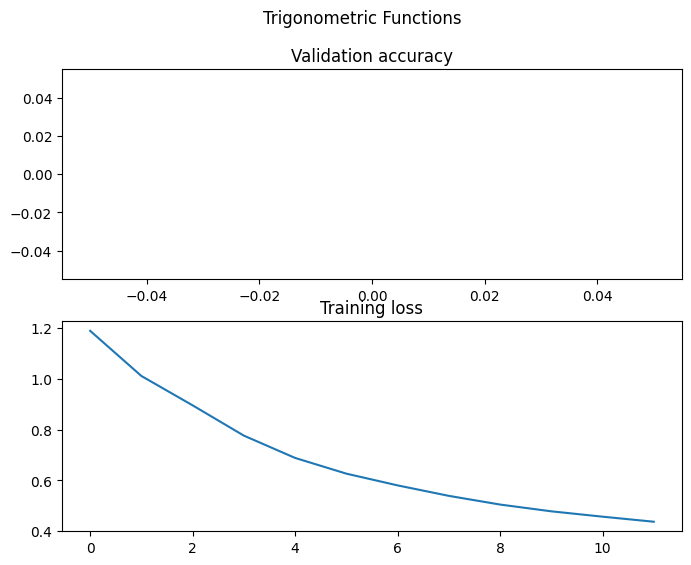

lr=4.4319243585806474e-05
Train loss: 0.41994494905214347


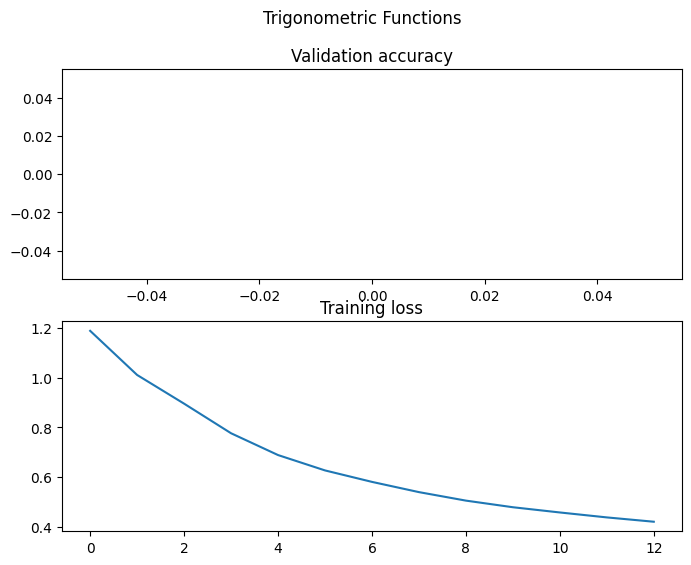

lr=4.387605114994841e-05
Train loss: 0.40450447437515535


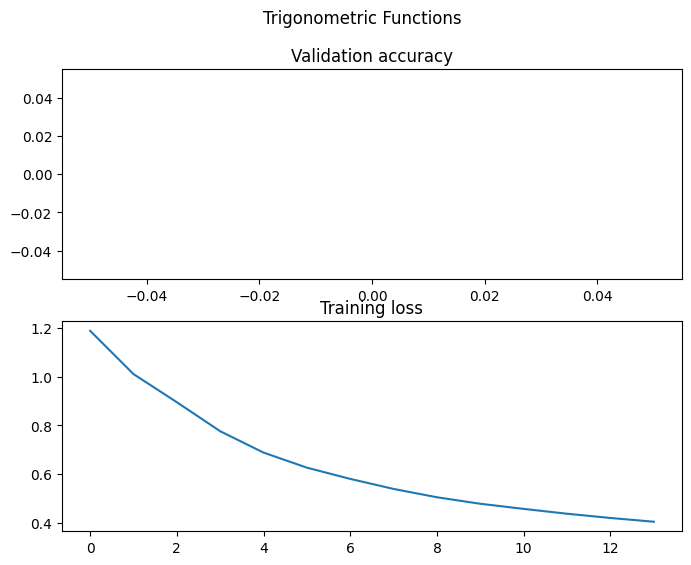

lr=4.343729063844893e-05
Train loss: 0.39102253615903626


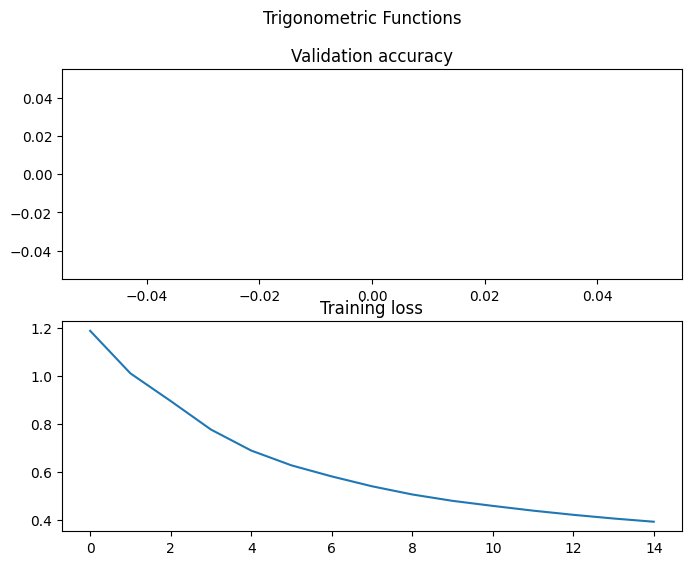

lr=4.3002917732064435e-05
Train loss: 0.37985273137741116


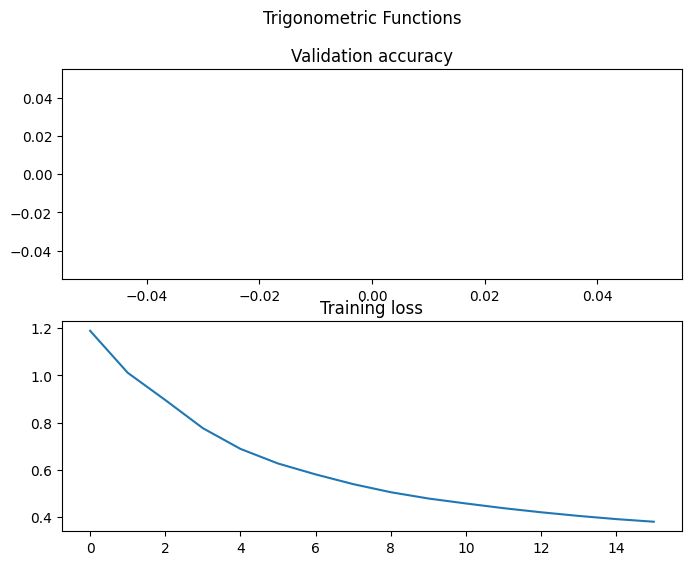

lr=4.257288855474379e-05
Train loss: 0.3692694994014049


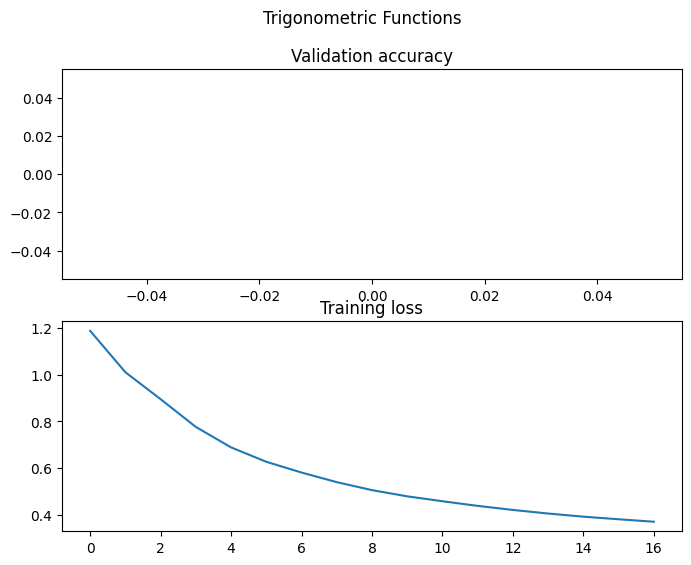

lr=4.214715966919636e-05
Train loss: 0.3587120639455281


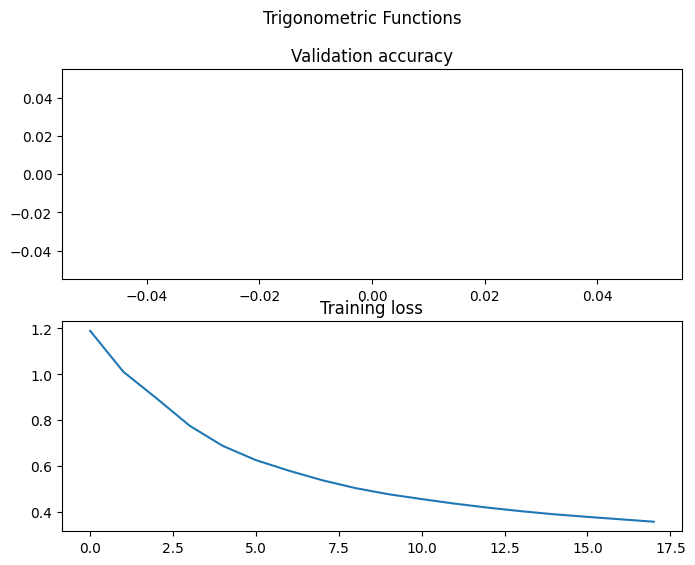

lr=4.1725688072504394e-05
Train loss: 0.34968365538663415


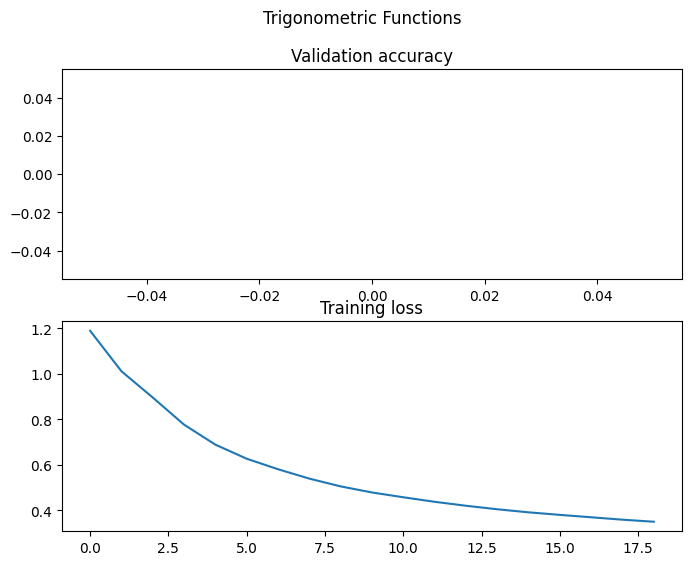

lr=4.130843119177935e-05
Train loss: 0.3416166993593497


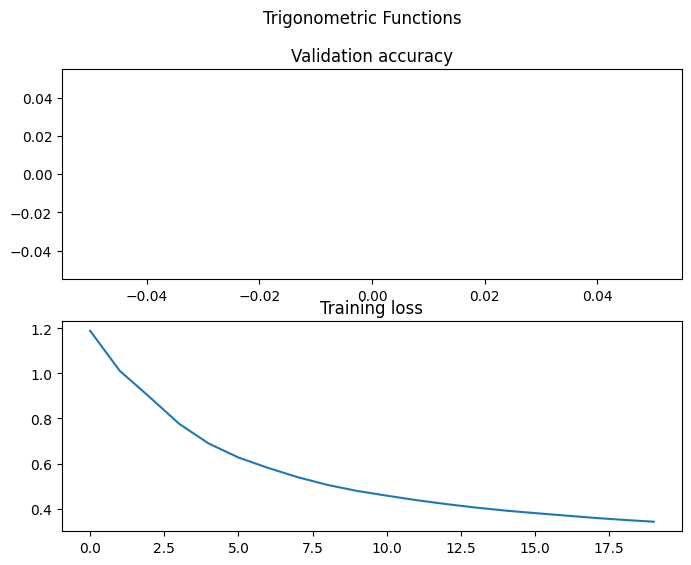

lr=4.089534687986155e-05
Train loss: 0.3336872413649557


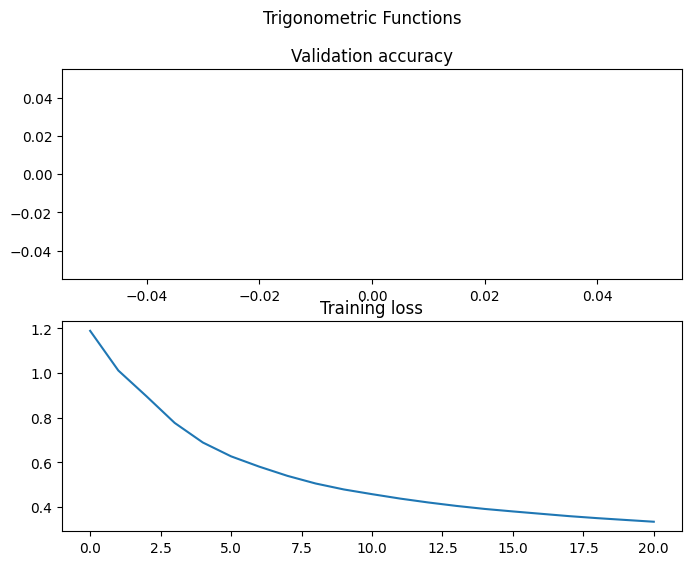

lr=4.0486393411062934e-05
Train loss: 0.3267079355556463


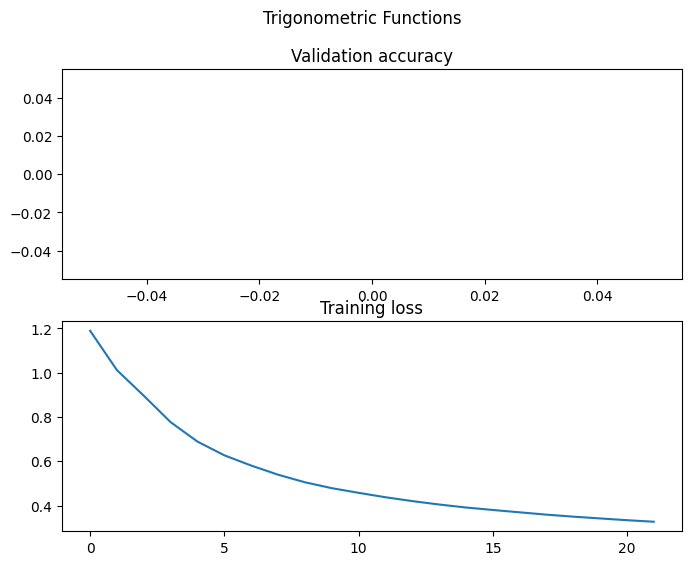

lr=4.0081529476952304e-05
Train loss: 0.31934237226096157


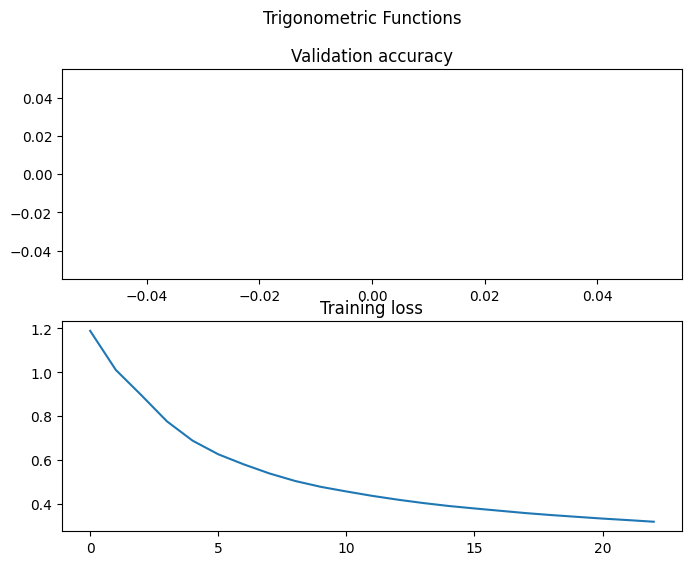

lr=3.968071418218278e-05
Train loss: 0.31301022332023687


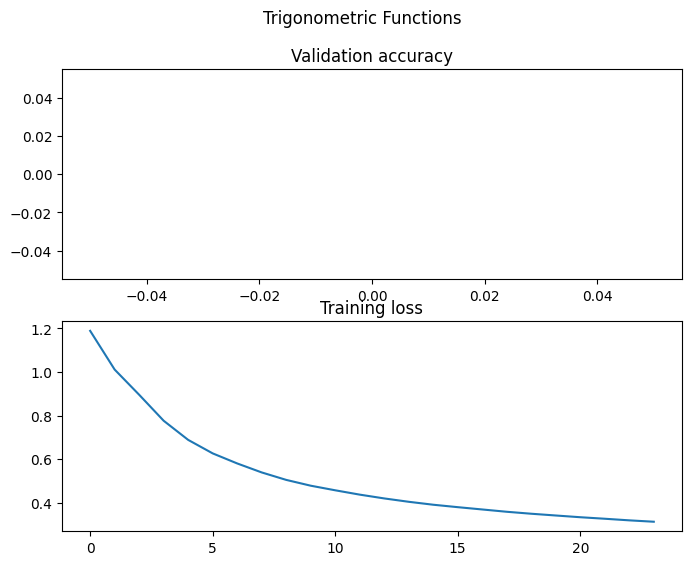

lr=3.9283907040360955e-05
Train loss: 0.306576628843185


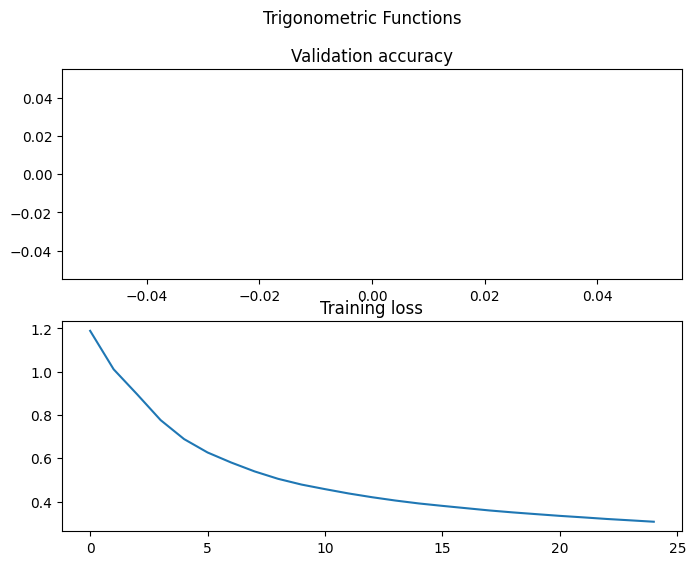

lr=3.8891067969957344e-05
Train loss: 0.31836988386553206


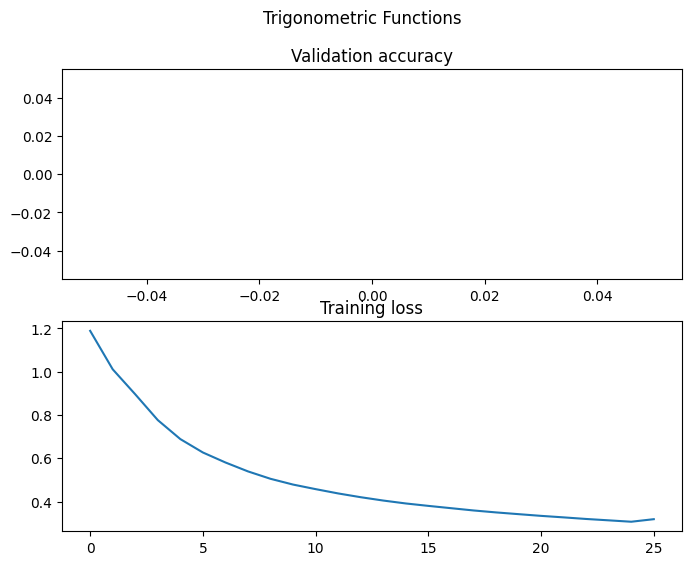

lr=3.850215729025777e-05
Train loss: 0.3273662590545655


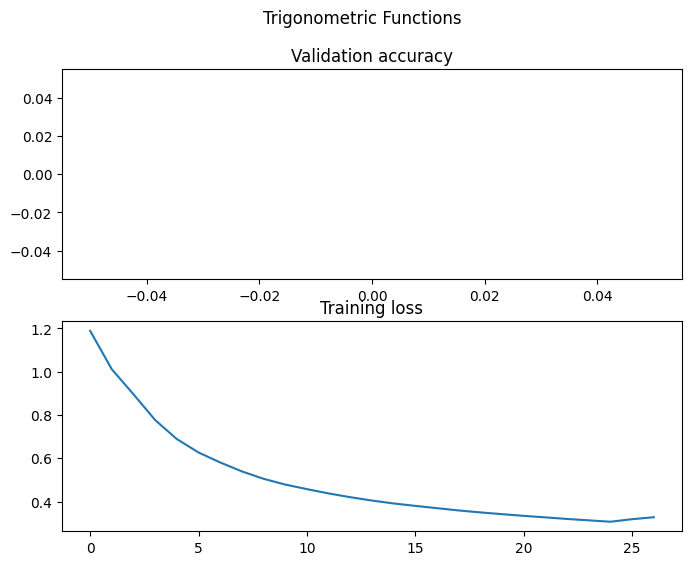

lr=3.811713571735519e-05
Train loss: 0.33522818618385114


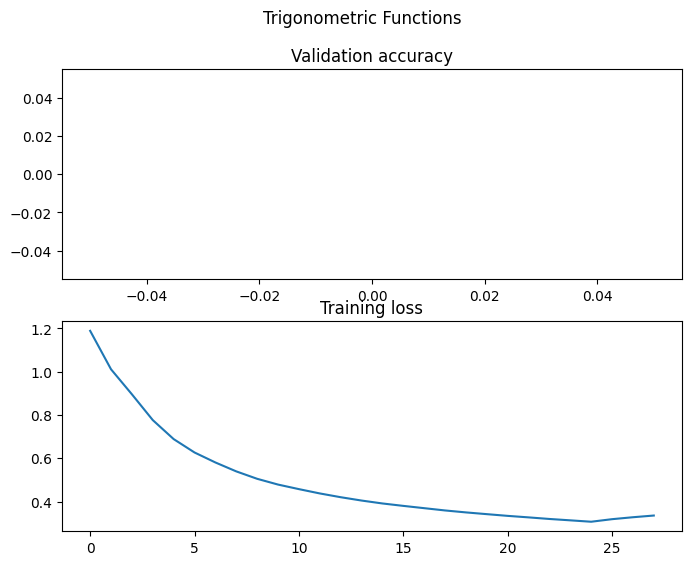

lr=3.773596436018164e-05
Train loss: 0.33244397779967455


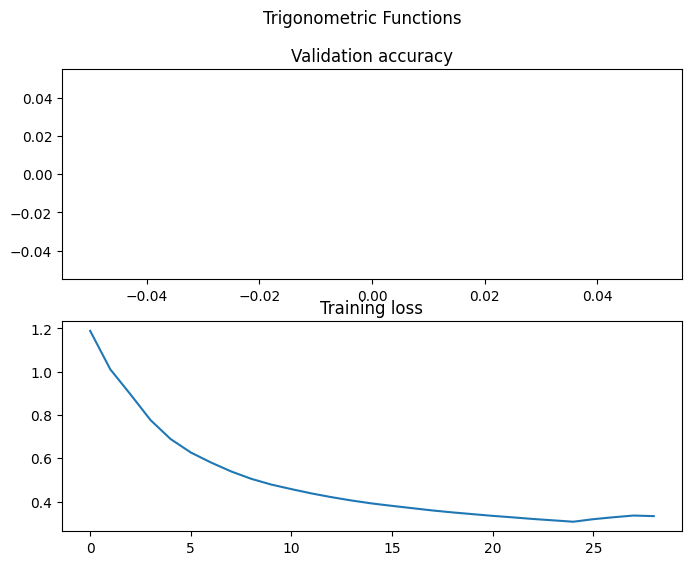

lr=3.735860471657982e-05
Train loss: 0.3263840836016614


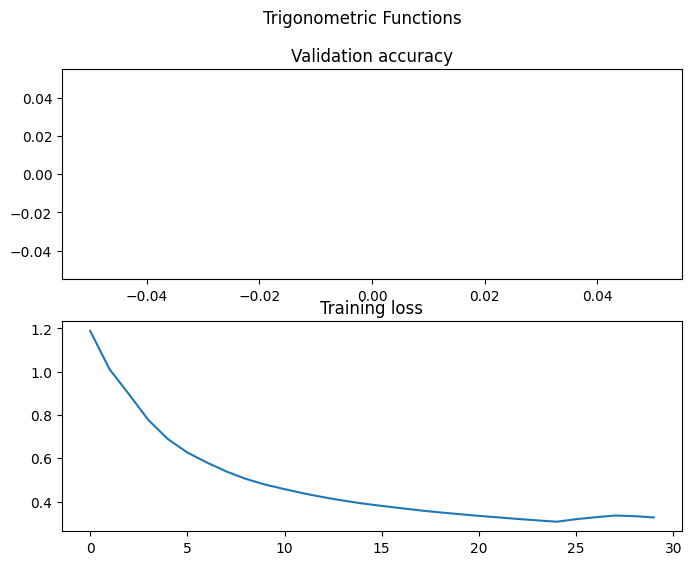

lr=3.698501866941402e-05
Train loss: 0.32018311141503497


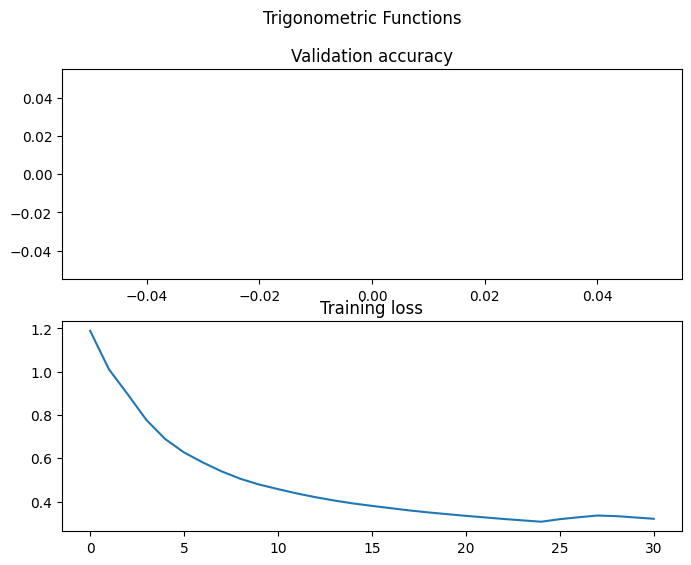

lr=3.661516848271988e-05
Train loss: 0.3144974204096298


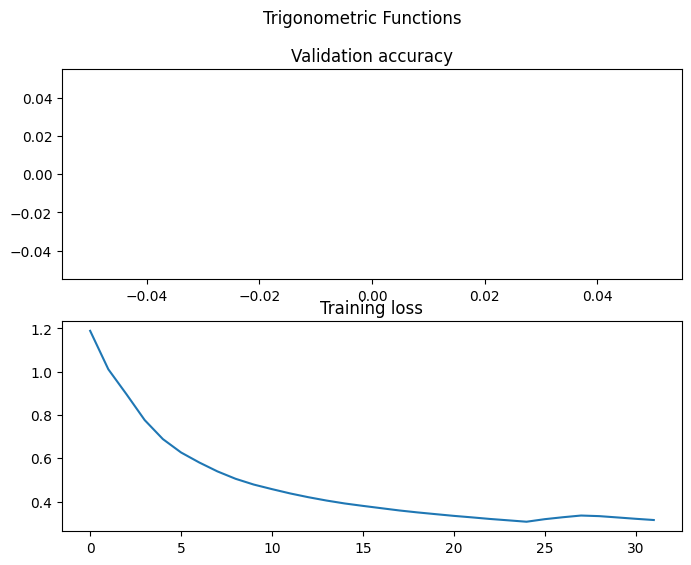

lr=3.6249016797892685e-05
Loss after epoch 1: 0.3135571833678263


  0%|          | 0/8034 [00:00<?, ?it/s]

c:\Users\Mytre\OneDrive\Документы\Data\Work\.env\lib\site-packages\transformers\generation\utils.py:1201: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


Validation accuracy: 0.8075258075258075
Validation cer:: 0.1603230103230103


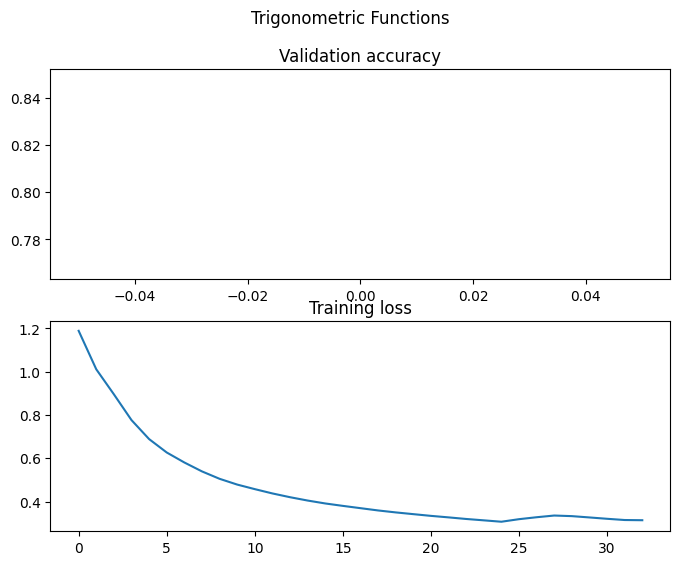

Validation accuracy: 0.8166666666666665
Validation cer:: 0.15959401251755076


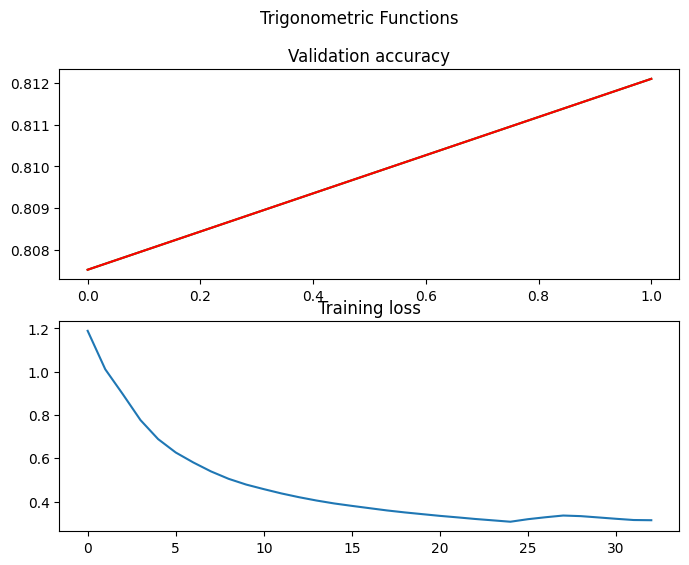

Validation accuracy: 0.82
Validation cer:: 0.15802748290252455


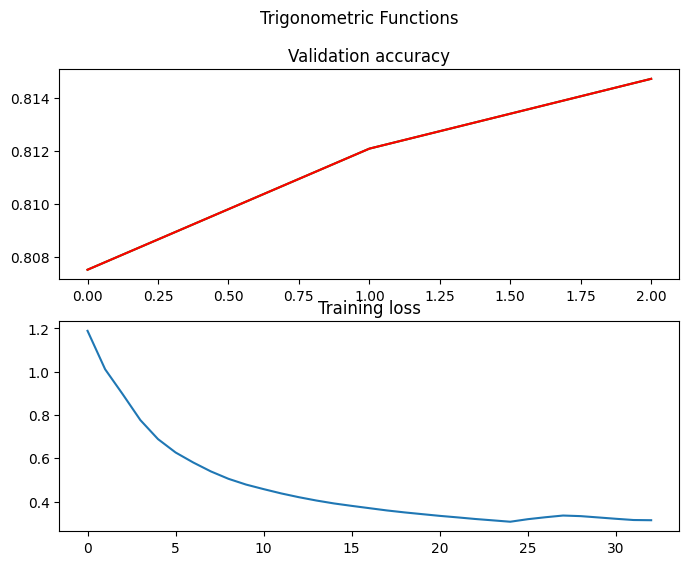

Validation accuracy: 0.8253333333333333
Validation cer:: 0.15703336070744217


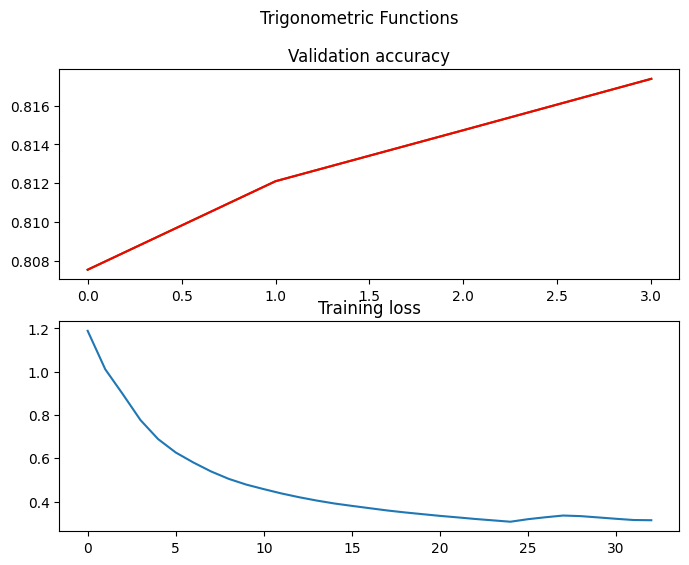

Validation accuracy: 0.8063333333333332
Validation cer:: 0.15814646594490625


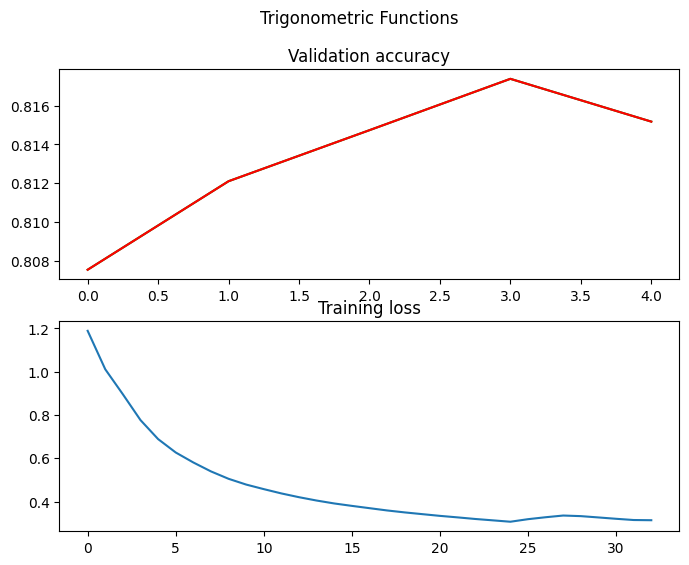

Validation accuracy: 0.8196666666666665
Validation cer:: 0.15785742058863203


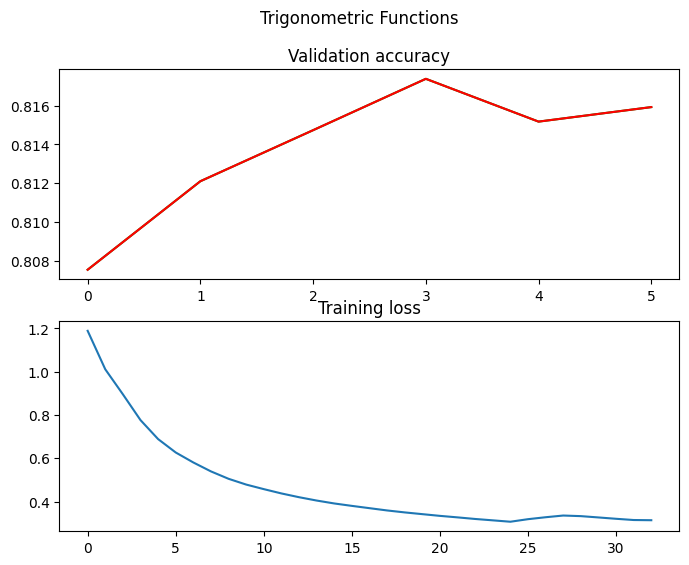

Validation accuracy: 0.8166666666666667
Validation cer:: 0.15730881982845987


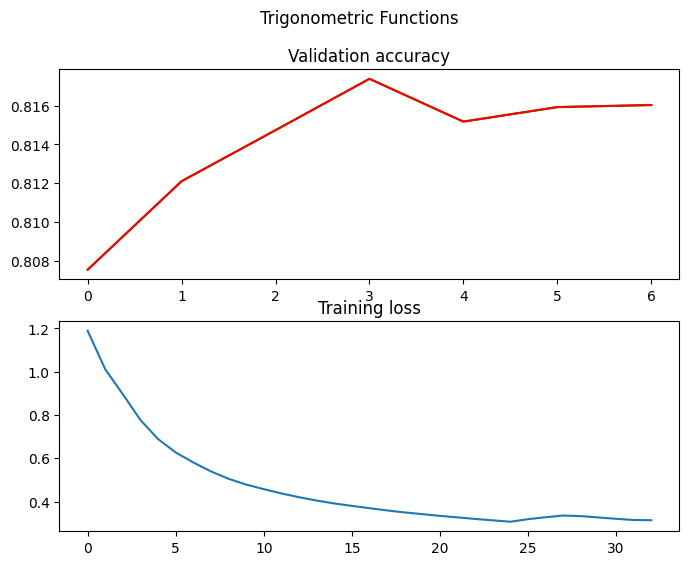

Validation accuracy: 0.8173333333333332
Validation cer:: 0.15701906309330382


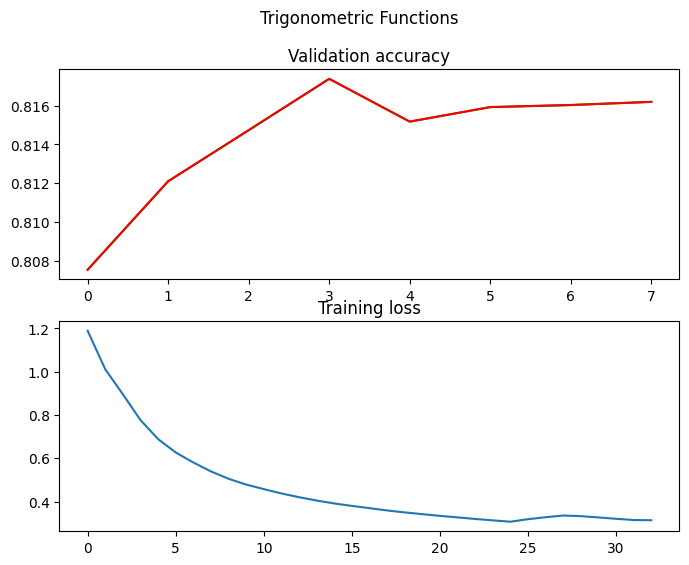

Model saved!!!
Total validation accuracy: 0.8159488839100489
Total validation cer: 0.15718108752089333


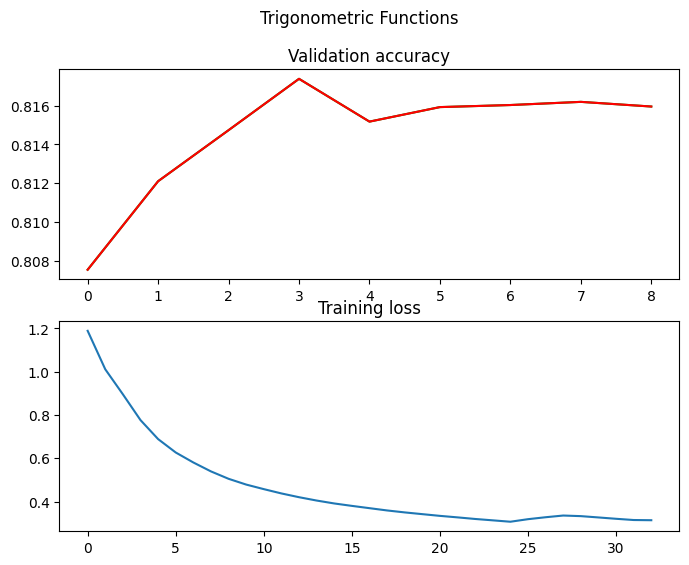

Epoch 2 start, lr=3.6249016797892685e-05


  0%|          | 0/32136 [00:00<?, ?it/s]

Train loss: 0.13953921369739056


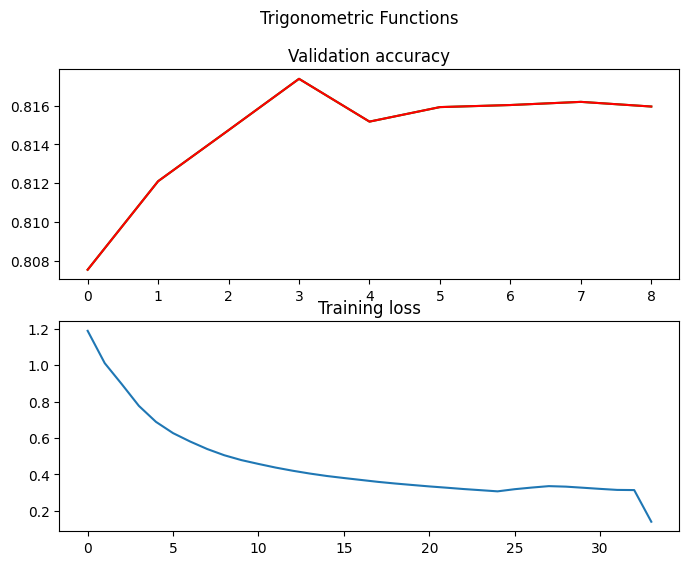

lr=3.588652662991376e-05
Train loss: 0.13046850565357787


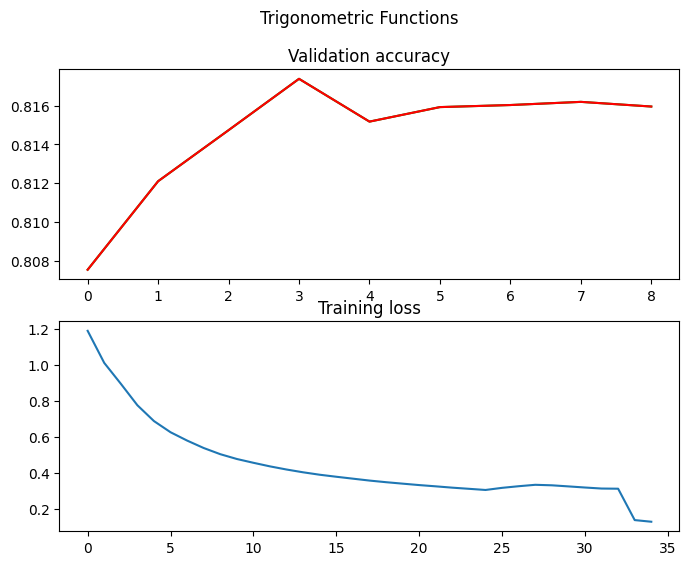

lr=3.552766136361462e-05
Train loss: 0.1323043132573077


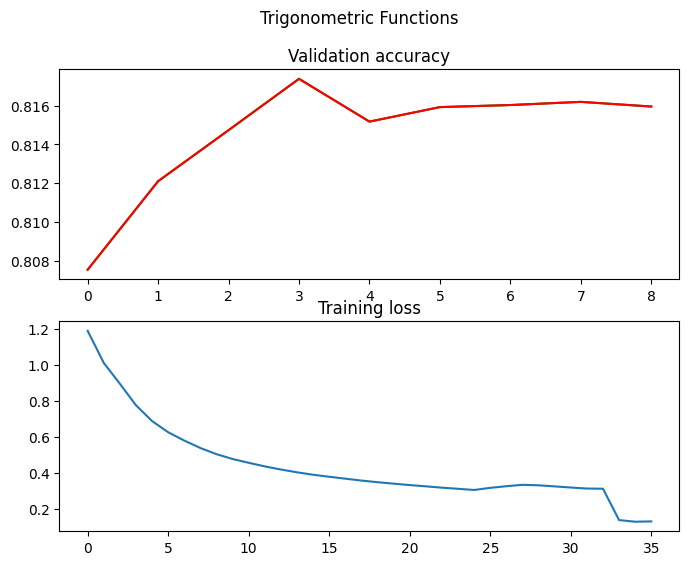

lr=3.5172384749978474e-05
Train loss: 0.13042345711855602


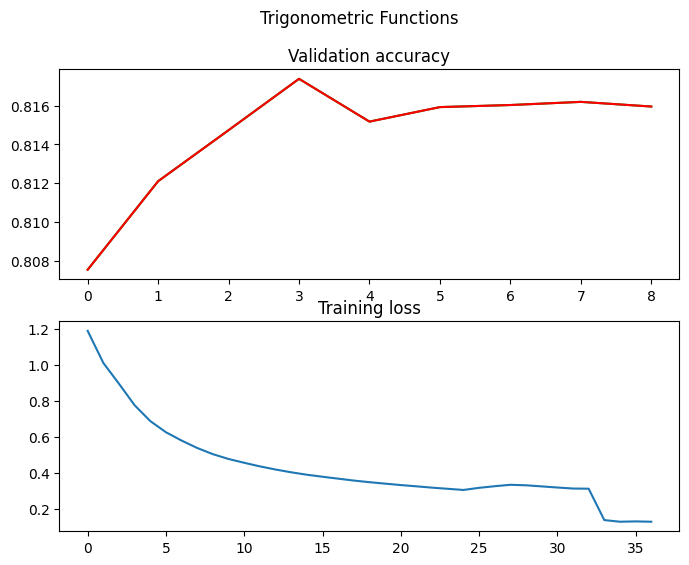

lr=3.482066090247869e-05
Train loss: 0.12877629239262103


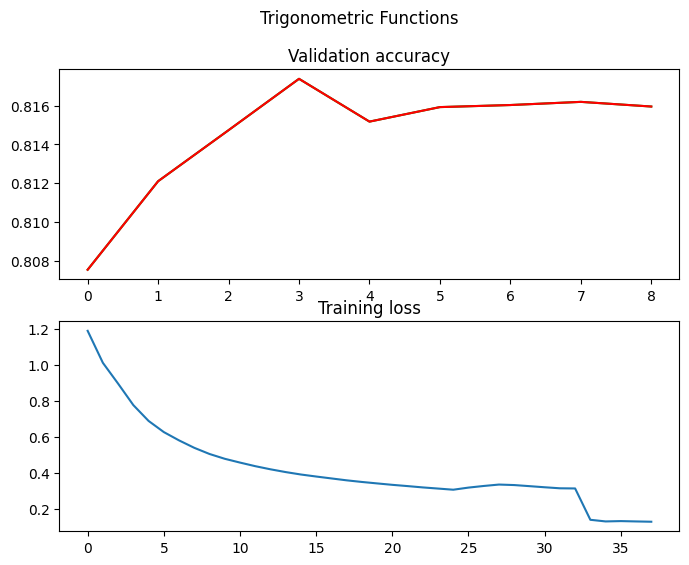

lr=3.44724542934539e-05
Train loss: 0.12789046366989976


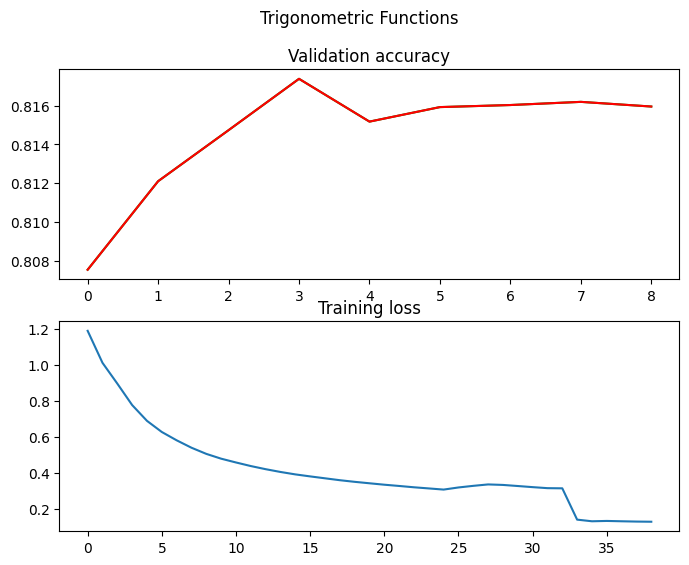

lr=3.412772975051936e-05
Train loss: 0.12784520298149105


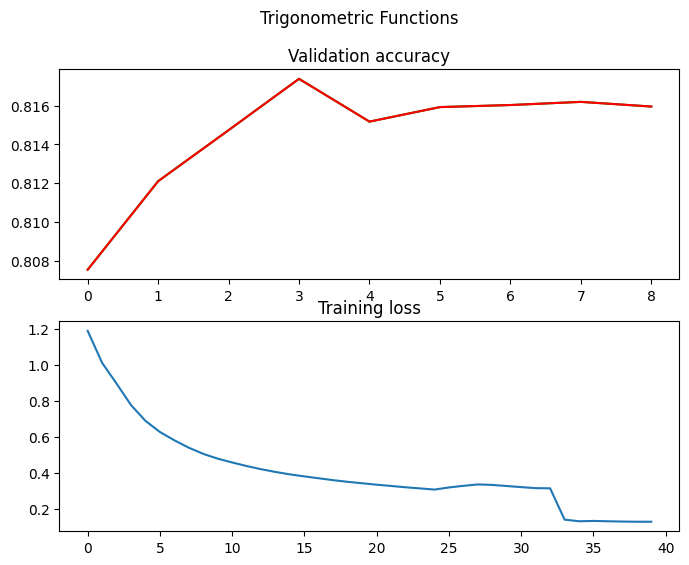

lr=3.378645245301417e-05
Train loss: 0.12714500826740507


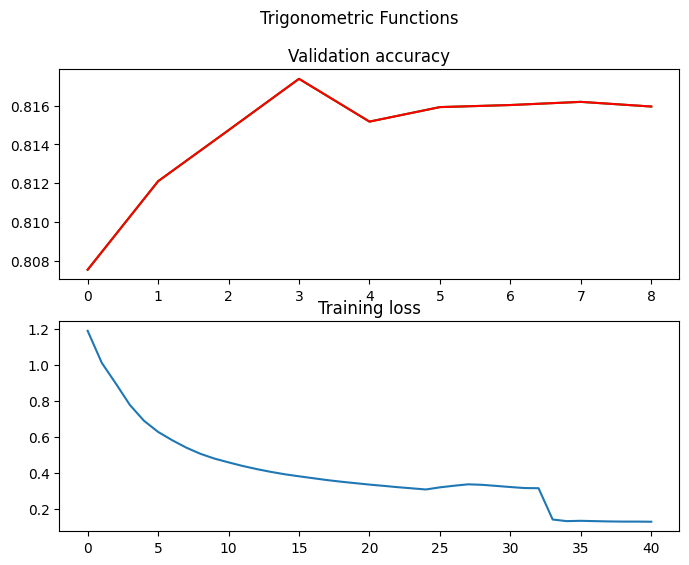

lr=3.344858792848402e-05
Train loss: 0.12608221007523698


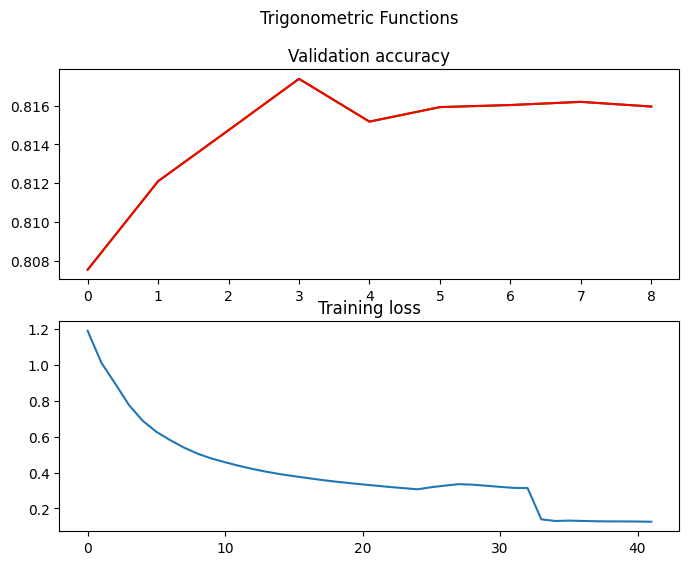

lr=3.3114102049199184e-05
Train loss: 0.12507049427247108


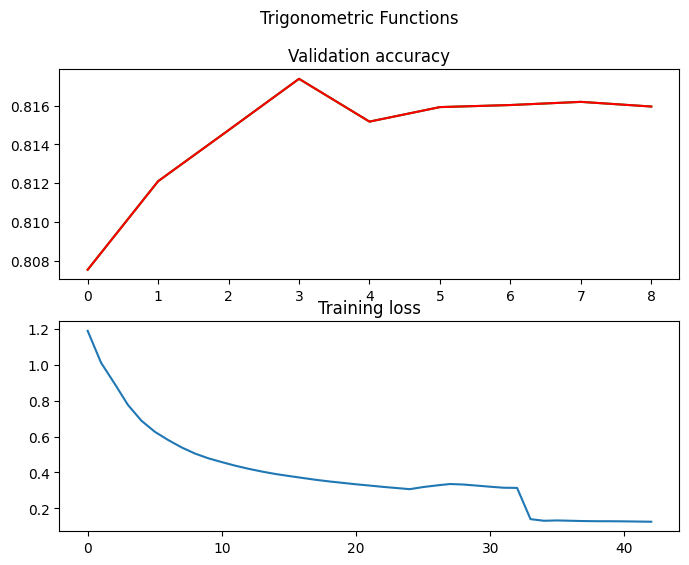

lr=3.2782961028707194e-05
Train loss: 0.12496433009690316


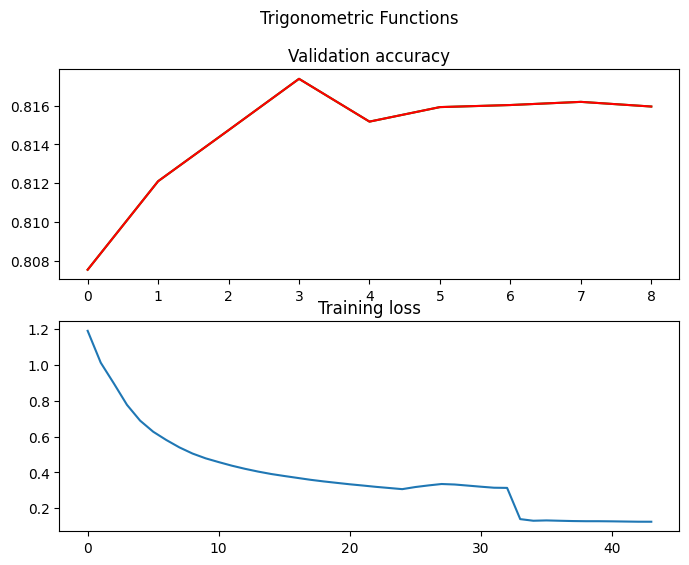

lr=3.2455131418420126e-05
Train loss: 0.12240693788267447


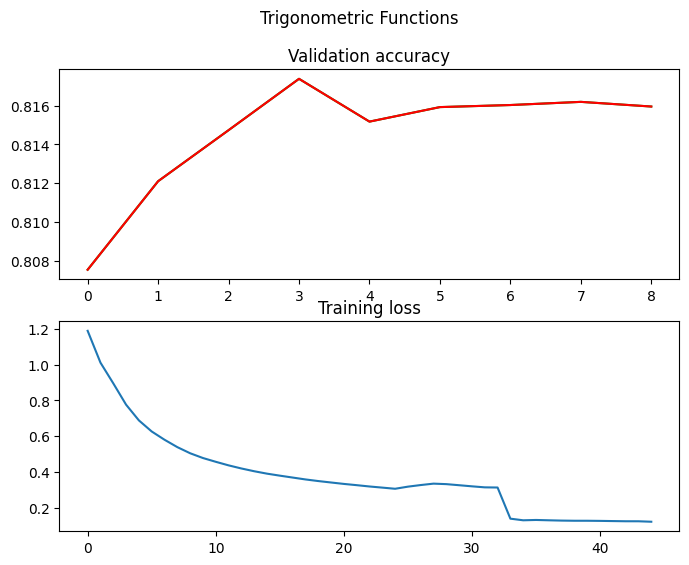

lr=3.213058010423592e-05
Train loss: 0.12186743036837391


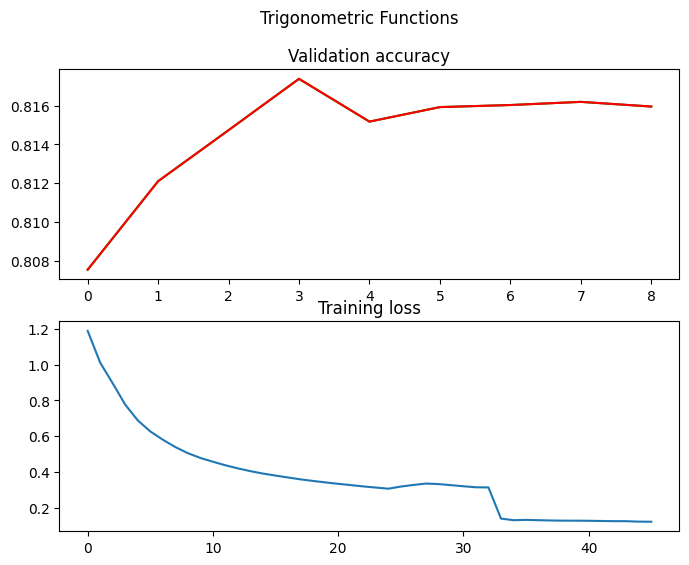

lr=3.180927430319356e-05
Train loss: 0.12135757852942543


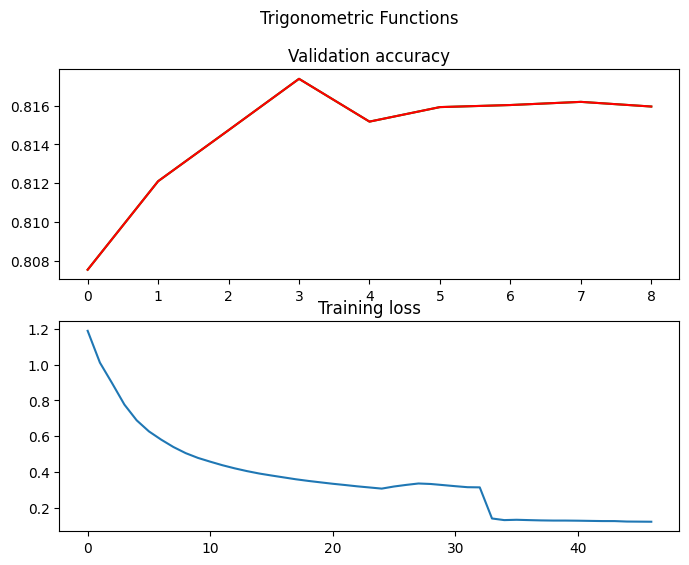

lr=3.149118156016163e-05
Train loss: 0.12118689809580013


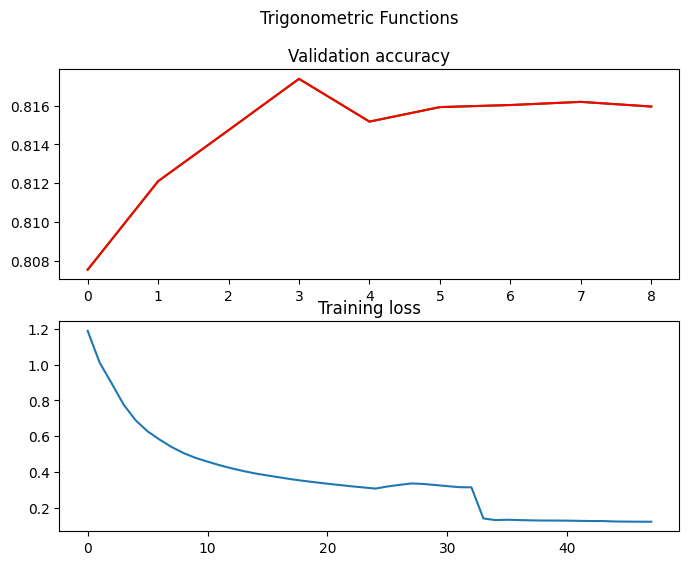

lr=3.117626974456001e-05
Train loss: 0.12038732142869892


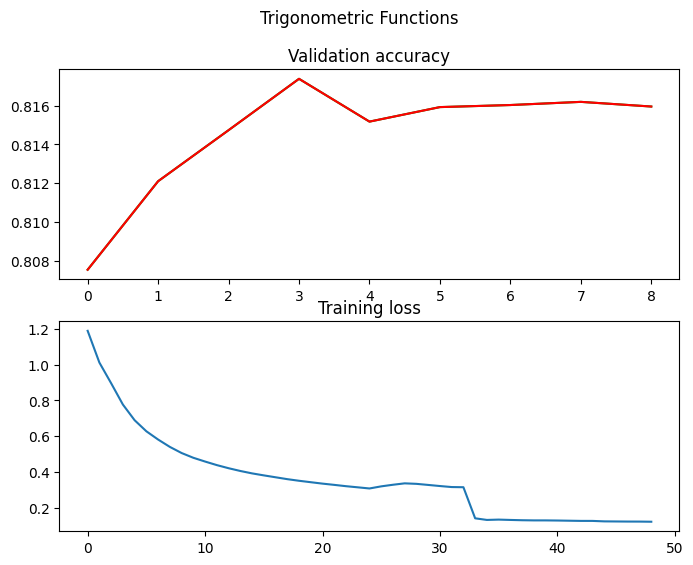

lr=3.086450704711441e-05
Train loss: 0.11994739152149234


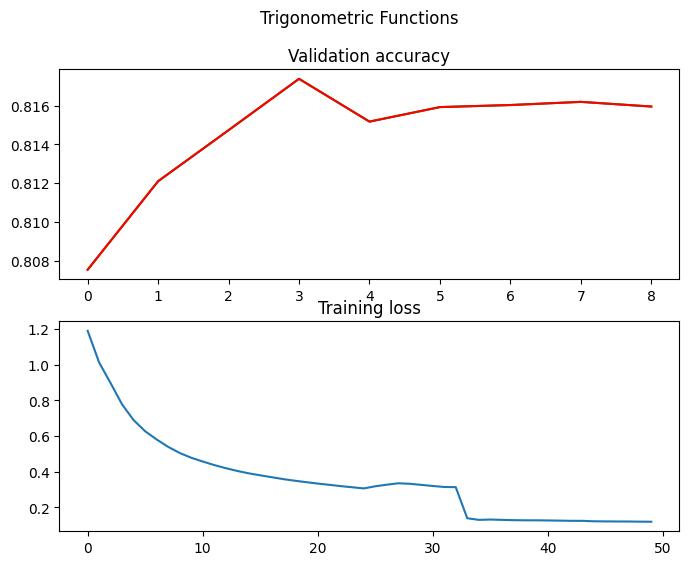

lr=3.055586197664326e-05
Train loss: 0.11935226686732342


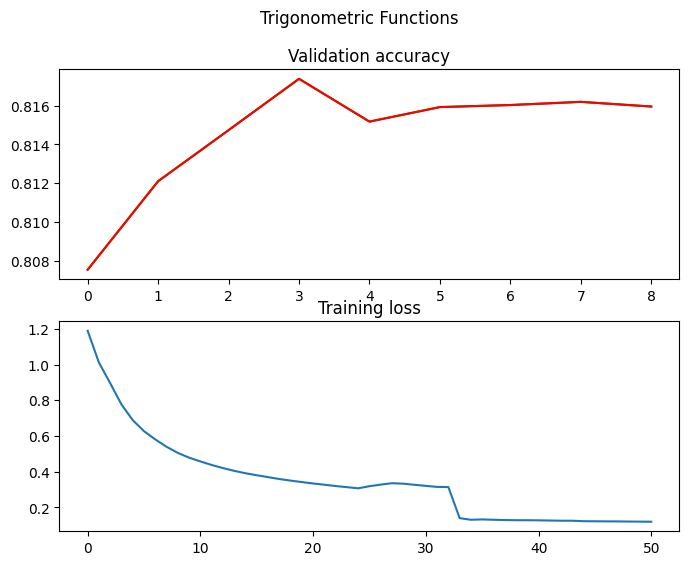

lr=3.025030335687683e-05
Train loss: 0.11905053790453343


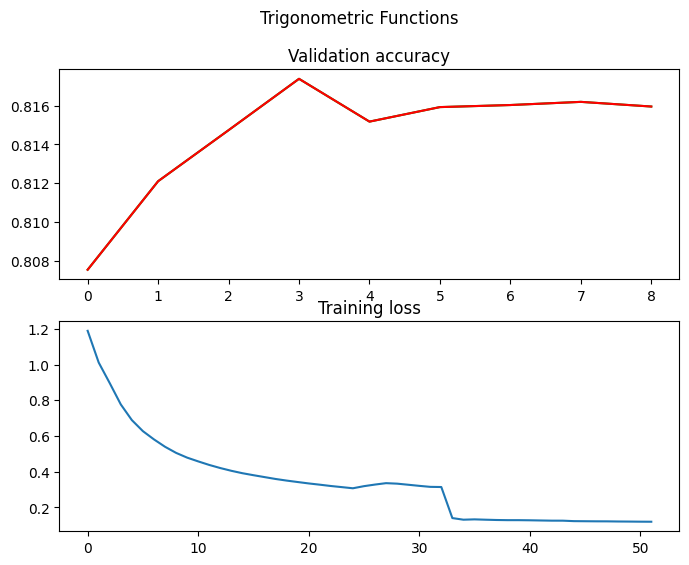

lr=2.9947800323308063e-05
Train loss: 0.11886153552203206


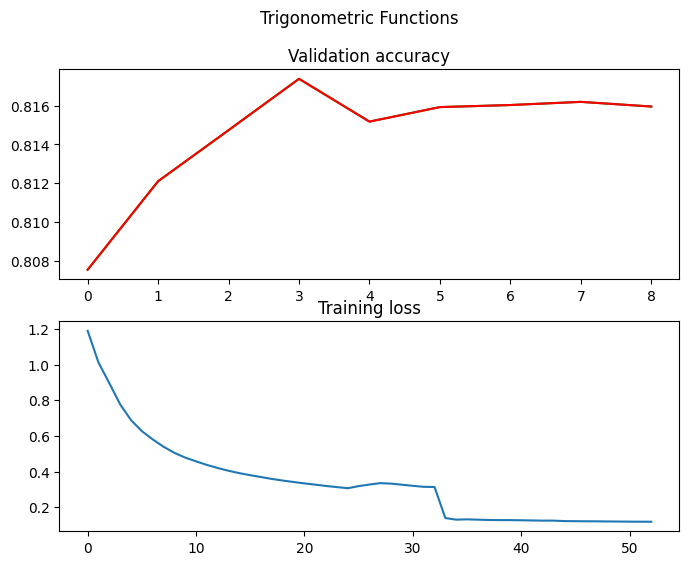

lr=2.9648322320074983e-05
Train loss: 0.11888530131133737


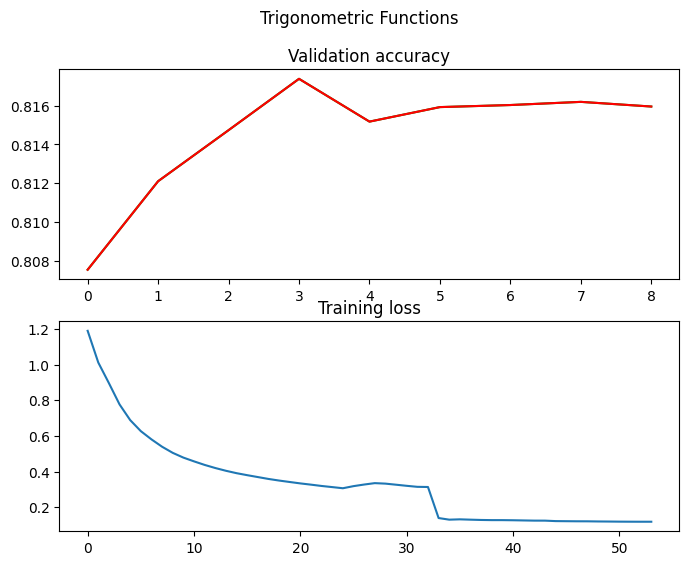

lr=2.9351839096874232e-05
Train loss: 0.1178993428573342


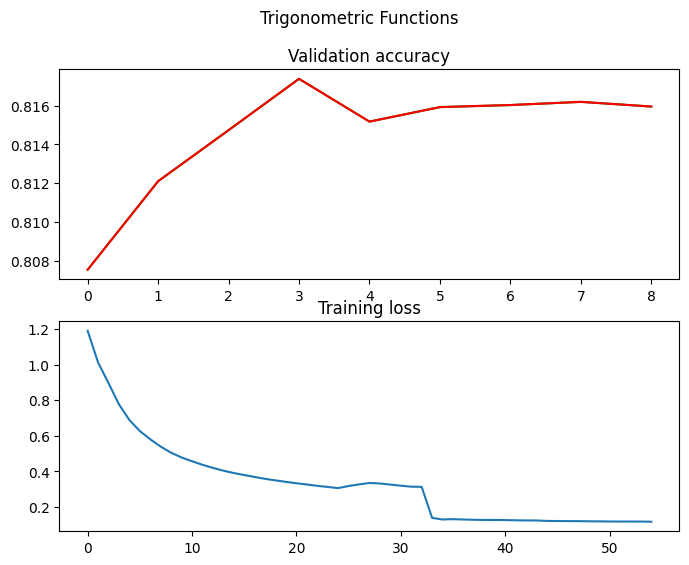

lr=2.905832070590549e-05
Train loss: 0.11729211420860287


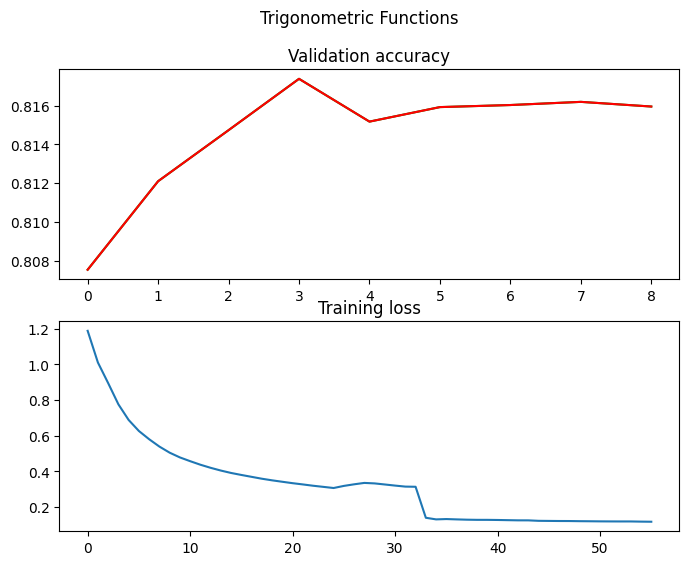

lr=2.8767737498846434e-05
Train loss: 0.1163129255517251


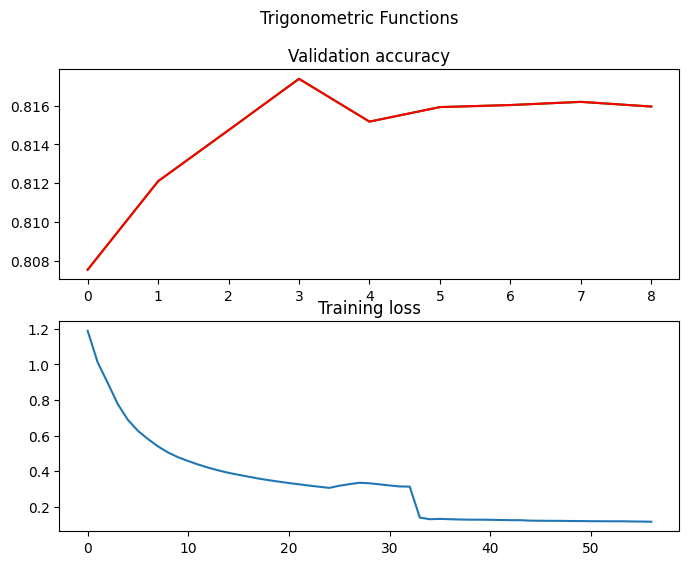

lr=2.848006012385797e-05
Train loss: 0.11556573037609687


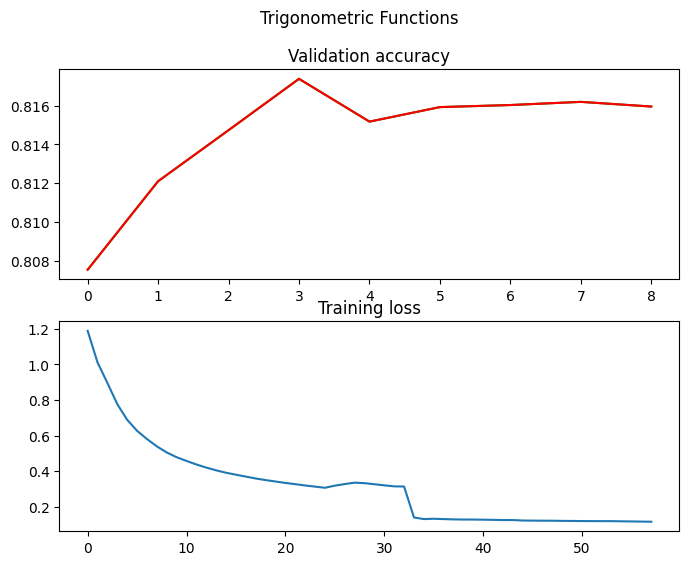

lr=2.819525952261939e-05
Train loss: 0.11510796538120155


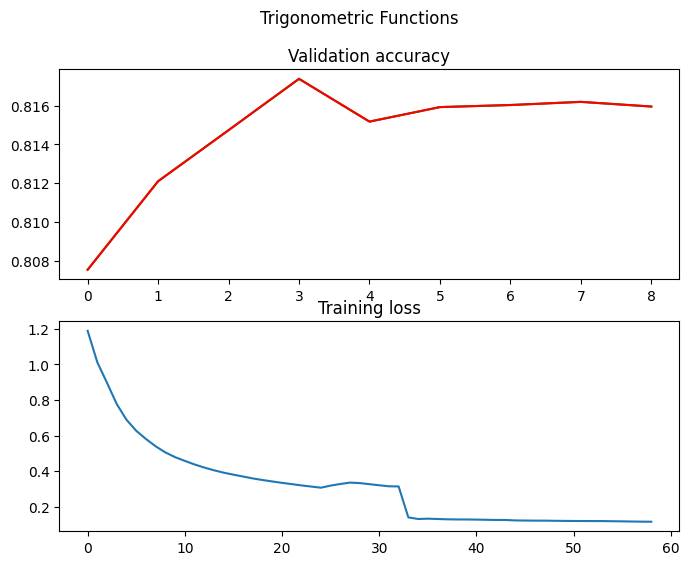

lr=2.7913306927393198e-05
Train loss: 0.11479334483616944


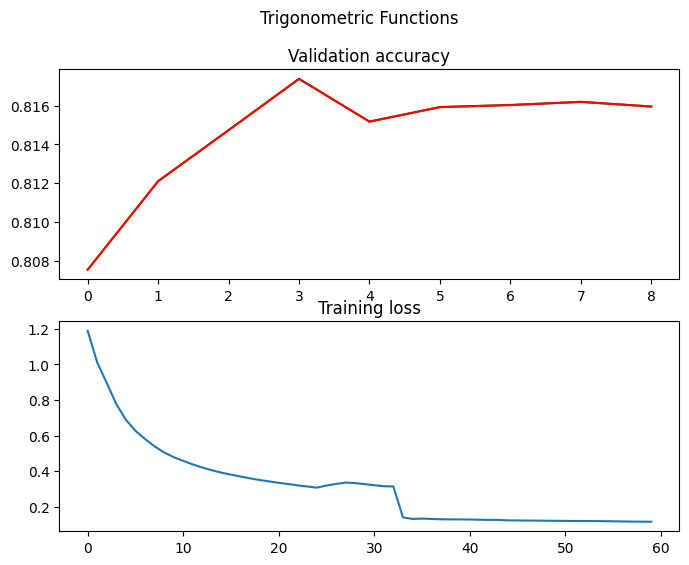

lr=2.7634173858119267e-05
Train loss: 0.11372051748274846


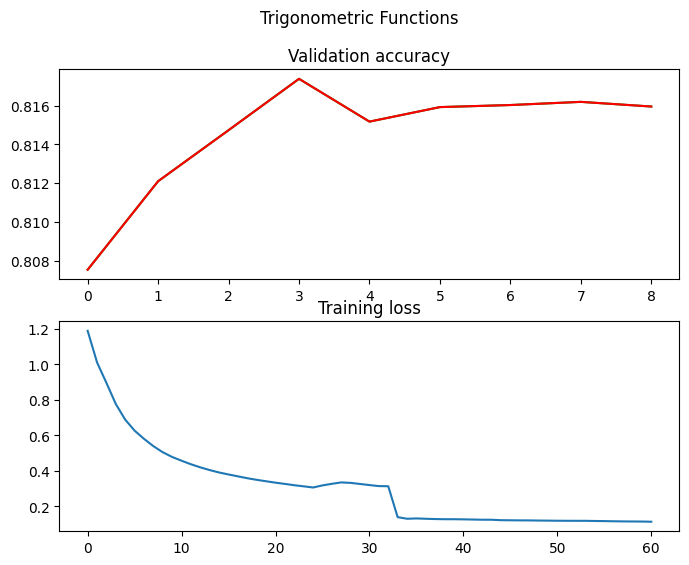

lr=2.7357832119538075e-05


In [15]:
step = 0
step_val = 0
accuracy = 0.
counter = 0
graf_loss = []
graf_acc = []

for epoch in range(100):  # loop over the dataset multiple times
    # train
    train_loss = []
    acc_batch = []
    train_loss_batch = []
    i, j = 0, 0

    model.train()
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f'Epoch {epoch + 1} start, lr={current_lr}')

    for batch in tqdm(train_dataloader):
        # get the inputs
        for k,v in batch.items():
            batch[k] = v.to(device)
        #break
        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        #acc = compute_acc(pred_ids=outputs, label_ids=target_text)
        #acc_train = compute_acc(pred_ids=outputs, label_ids=batch["labels"])
        #acc_batch.append(acc_train['accuracy'])
        train_loss.append(loss.item())
        train_loss_batch.append(loss.item())

        if (i % 1000 == 0) & (i > 2 ):
            print(f'Train loss: {np.mean(train_loss_batch)}')
            #tensor_board.add_scalar('Train loss:', np.mean(train_loss_batch), global_step=step)   
            #tensor_board.add_scalar('Validation accuracy:', np.mean(acc_batch), global_step=step_val)   
            mean_loss = np.mean(train_loss)
            graf_loss.append(mean_loss)

            step += 1
            scheduler.step()
            current_lr = optimizer.param_groups[0]['lr']
            
            drow_graf(graf_acc, graf_loss)
            print(f'lr={current_lr}')
    
        i += 1

    mean_loss = np.mean(train_loss)   
    print(f"Loss after epoch {epoch + 1}:", mean_loss)
    graf_loss.append(mean_loss)
    # evaluate
    model.eval()

    valid_acc = []
    valid_cer = []
    valid_acc_batch = []
    valid_cer_batch = []

    with torch.no_grad():
        for batch in tqdm(eval_dataloader):
            # run batch generation          
            target_text = processor.batch_decode(batch['labels'], skip_special_tokens=True)
            #target_text = [int(x) for x in target_text]
       
            outputs = model.generate(batch["pixel_values"].to(device), max_new_tokens=4)
            # compute metrics
            
            acc = compute_acc(pred_ids=outputs, label_ids=target_text)
            cer = compute_cer(pred_ids=outputs, label_ids=batch['labels'])           
            #print(outputs)
            valid_cer.append(cer)       
            valid_acc.append(acc['accuracy'])  
            valid_acc_batch.append(acc['accuracy']) 
            valid_cer_batch.append(cer)

            if (j % 1000 == 0) & (j > 2 ):
                print(f'Validation accuracy: {np.mean(valid_acc_batch)}')
                print(f'Validation cer:: {np.mean(valid_cer_batch)}')

                #tensor_board.add_scalar('Validation accuracy:', np.mean(valid_acc_batch), global_step=step_val)
                #tensor_board.add_scalar('Validation cer:', np.mean(valid_cer_batch), global_step=step_val)
                mean_acc =  np.mean(valid_acc)   
                graf_acc.append(mean_acc)

                valid_acc_batch = []
                valid_cer_batch
                step_val += 1

                drow_graf(graf_acc, graf_loss)
            j += 1 
            
        counter += 1    
        if np.mean(valid_acc) > accuracy:
            model.save_pretrained('model_best')    
            accuracy = np.mean(valid_acc)
            counter = 0
            print('Model saved!!!')

        if counter > 5:
            print('Early stopping!!!')
            print(f'Result validation accuracy: {accuracy}')
            break

        mean_acc =  np.mean(valid_acc)   
        graf_acc.append(mean_acc)
        print("Total validation accuracy:", mean_acc)
        print("Total validation cer:", np.mean(valid_cer))

        drow_graf(graf_acc, graf_loss)

Проветим обученную модель на тестовом датасете

In [ ]:
from sklearn.metrics import accuracy_score

torch.cuda.empty_cache()
# Define the device to run the evaluation on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the model to evaluation mode
model.eval()
model.to(device)
# Evaluate the model on the eval dataset
diff_acc = []
acc = []
i = 0

with torch.no_grad():
    for batch in tqdm(test_dataloader):
    
        target_text = processor.batch_decode(batch['labels'], skip_special_tokens=True)
        target_text = [int(x) for x in target_text]
           
        pixel_values = batch['pixel_values']
        generated_ids = model.generate(pixel_values.cuda(), max_new_tokens=4)       
       
        # Make a prediction
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)

        x = [] 
        for j in generated_text:       
            if j.isdigit():
                x.append(int(j))
            else:
                x.append(1000)        
      
        bach_acc = accuracy_score(target_text, x)
        # Save the true and predicted labels
        diff_acc.append(bach_acc)  
        acc.append(bach_acc)

        if (i % 50  == 0) & (i > 2):
            accuracy = np.mean(diff_acc)
            print("Accuracy:", accuracy) 
        i += 1

    print(f"Total accuracy: {np.mean(acc)}")    

ValueError: x and y must have same first dimension, but have shapes (1,) and (3,)

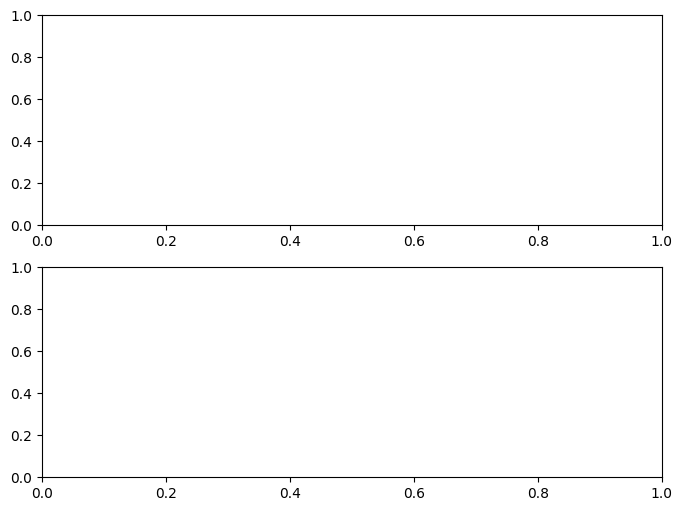

In [79]:
acc = [3, 4, 8]
loss = [4, 7, 3]
drow_graf(acc, loss)